In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime


pd.set_option('max_colwidth', 140)

In [2]:
!head -1 ../rowling.json

{"reviewerID": "A2KPBO9MLTTOZZ", "asin": "0002226618", "reviewerName": "Jens Guld", "helpful": [1, 1], "reviewText": "There aren't many public school novels being written and read these days. Rowling's Potter series is an exception (and in my opinion they are not all that good). However if you are old enough to have read Tom Brown's Schooldays then the Flaashman series may be of interest. If you have enjoyed Kipling's Indian stories then Flashman is also worth a try.", "overall": 5.0, "summary": "For kiplomaniacs", "unixReviewTime": 1340496000, "reviewTime": "06 24, 2012"}


In [3]:
# load up the data
df = pd.read_json('../rowling.json',lines=True)

In [4]:
df['helpful_votes'] = df.apply(lambda x: x.helpful[0],axis=1)
# df['unhelpful_votes'] = df.apply(lambda x: x.helpful[1],axis=1)
df.reviewTime = pd.to_datetime(df.reviewTime,infer_datetime_format=True)
df.sort_values(by=['reviewTime'],inplace=True,ascending=True)
last_rvw = df.reviewTime.max()
df['review_age_days'] = df.apply(lambda x: (last_rvw - x.reviewTime).days,axis = 1)


In [8]:
# df.asin.value_counts()

# Surely some of these others are the HP books
# 0316228532    616 Casual Vacancy pubd 9/2012
# 0439136350    HP3 Prisoner of Azkaban
# 030728364X    469 HP6 Half-Blood Prince
# 043935806X    271 HP5 Order of the Phoenix
# 043920352X    263 HP1 Sorceror's Stone pubd 6/1997
# 0316206849    214 The Cuckoo's Calling
# 0439139597    192 HP4 Goblet of Fire
# 0439064864    133 HP2 Chamber of Secrets
# 0545128285     82 Tales of Beedle the Bard
# 0452296293     33 (not rowling)
# Please note HP7 hadn't been published yet!

In [55]:
cv = df[df.asin == "0316228532"].copy()

In [13]:
cv['helpful_votes'] = cv.apply(lambda x: x.helpful[0],axis=1)
cv['unhelpful_votes'] = cv.apply(lambda x: x.helpful[1],axis=1)

In [36]:
# cv.head()

In [15]:
cv[cv.helpful_votes == 0].shape[0]

166

Text(0.5,1,"JK Rowling's Casual Vacancy - published Sep 2012")

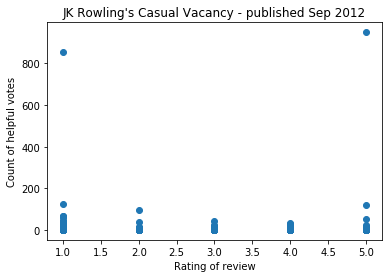

In [16]:
plt.scatter(x=cv.overall,y=cv.helpful_votes)
plt.ylabel("Count of helpful votes")
plt.xlabel("Rating of review")
plt.title("JK Rowling's Casual Vacancy - published Sep 2012")

Note strong non-linearity above; much more of a "U" shape

In [29]:
a = cv.helpful_votes.quantile(np.arange(0,1,.05))

Text(0.5,0,'Quantile of reviews receiving that many votes - or more')

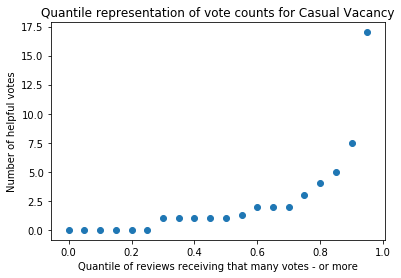

In [34]:
plt.scatter(x=a.index,y=a)
plt.title("Quantile representation of vote counts for Casual Vacancy")
plt.ylabel("Number of helpful votes")
plt.xlabel("Quantile of reviews receiving that many votes - or more")

Here we find that 20% of the reviews get no helpful votes. 80% of the reviews get 4 or fewer votes. The top 10% of reviews are getting more than 7 votes.

In [89]:
# verified HP books
# df[df.asin == "0545128285"].head()

In [84]:
az = df.reviewText.str.contains('seventh', regex=False)
print(np.sum(az),"meet that criteria")
df[az == True].head()

In [9]:
# HPbooks = {6:"030728364X",5:"043935806X",1:"043920352X",4:"0439139597",2:"0439064864"}

In [5]:
qts = pd.DataFrame({'x':np.arange(0,1,.05),\
                    'HP1':df[df.asin == "043920352X"].helpful_votes.quantile(np.arange(0,1,.05)),\
                    'HP2':df[df.asin == "0439064864"].helpful_votes.quantile(np.arange(0,1,.05)),\
                    'HP3':df[df.asin == "0439136350"].helpful_votes.quantile(np.arange(0,1,.05)),\
                    'HP4':df[df.asin == "0439139597"].helpful_votes.quantile(np.arange(0,1,.05)),\
                    'HP5':df[df.asin == "043935806X"].helpful_votes.quantile(np.arange(0,1,.05)),\
                    'HP6':df[df.asin == "030728364X"].helpful_votes.quantile(np.arange(0,1,.05))})

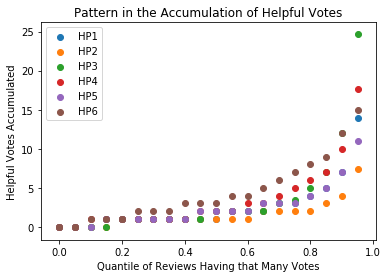

In [7]:
# multiple line plot
plt.scatter( x='x', y='HP1', data=qts)
plt.scatter( x='x', y='HP2', data=qts)
plt.scatter( x='x', y='HP3', data=qts)
plt.scatter( x='x', y='HP4', data=qts)
plt.scatter( x='x', y='HP5', data=qts)
plt.scatter( x='x', y='HP6', data=qts)
plt.legend()
plt.title("Pattern in the Accumulation of Helpful Votes")
plt.ylabel("Helpful Votes Accumulated")
plt.xlabel("Quantile of Reviews Having that Many Votes")
plt.savefig("HP_reviews_helpful_vote_accumulation.png")

In [8]:
!ls

Cleanup_book_cutoffs.ipynb
EDA_of_labeled_data.ipynb
HP_reviews_helpful_vote_accumulation.png
HVAR_small_EDA.ipynb
Labeling_dev.ipynb
Labeling_small.ipynb
Labeling_test.ipynb
Labeling_toy.ipynb
Labeling_train.ipynb
Last_dates_dev_test.ipynb
Predicting_Amazon_Book_Review_Helpfulness_using_BERT_on_TF_Hub (1).ipynb
Prelim_EDA_of_small_train.ipynb
Prelim_EDA_of_toy_train.ipynb
Prelim_handling_train_dataset.ipynb
README.md
Rowling_EDA.ipynb
Using BERT to augment the R3 system with relevance ranking.ipynb
Using_LIME_for_BERT_introspection.ipynb


There appears to be a fairly consistent 'elbow'/hinge effect at around the 75% quartile. I think it makes some sense for us to decide that a review is "helpful" if it falls in that book's top quartile, and "unhelpful" if it falls in that book's bottom quartile. Everything in between we might treat as noise ... or could possibly boost a mediocre review slightly in our display if sentences match the query (and more helpful reviews have no similar content).

In [9]:
hp = df[(df.asin == "043920352X") | (df.asin == "0439064864") | \
        (df.asin == "0439136350") | (df.asin == "0439139597") | \
        (df.asin == "043935806X") | (df.asin == "030728364X")].copy()

In [17]:
hp.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful_votes,unhelpful_votes,review_age_days
1452,043920352X,"[0, 1]",5,"As a librarian, I look for books to entice my students. This is one of the best I have found. I began reading this to a group of 6th g...",1999-04-08,A3QYW1CL3A9L5P,"Karen Kirsch ""blazerlib""",A must for my media center,923529600,0,1,5579
2936,043920352X,"[1, 1]",4,"Magic, children who are magic belatedly being discovered, alternate worlds, worlds coexisting within others, enchanted beings, weirdly f...",1999-06-23,A1LXLB93XP9WWB,A Reader,"Entertaining, especially for those with short memories",930096000,1,1,5503
812,0439064864,"[2, 2]",5,"The Harry Potter books are my favorite new reading find, and I can't say enough good things about them. This latest in the Harry Potter...",1999-08-26,A3SPVFFXG90YIG,Dean Gloster,Another great book for 6 to 60 year olds from J.K. Rowling.,935625600,2,2,5439
3631,0439136350,"[1, 2]",3,"The first two &quot;Harry Potter&quot; books were splendid. They had heart, warmth and imagination to spare. &quot;Harry Potter and th...",1999-10-04,AC1K4OQOZ90RS,"E. Bukowsky ""booklover10""","This book is too long, too convoluted and too dour.",938995200,1,2,5400
1450,043920352X,"[0, 1]",5,"Has anyone noticed that those who review this book at three stars or less and REALLY MEAN IT cannot spell, or put a sentence together?To...",1999-10-16,A18LI12Y8C49YN,"Joy McCann ""Attila Girl""",it's really five stars,940032000,0,1,5388


Text(0.5,1,'Harry Potter Series')

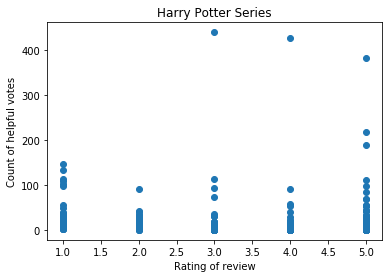

In [18]:
plt.scatter(x=hp.overall,y=hp.helpful_votes)
plt.ylabel("Count of helpful votes")
plt.xlabel("Rating of review")
plt.title("Harry Potter Series")

Not a "U" shape this time, but certainly not a linear relationship between book stars and helpful votes

Text(0,0.5,'Review age in days')

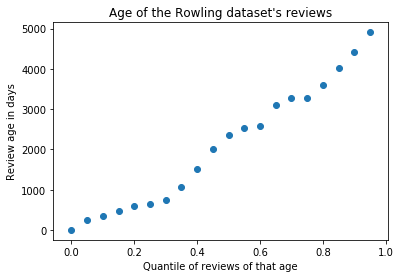

In [19]:
plt.scatter(x = np.arange(0,1,.05), y = df.review_age_days.quantile(np.arange(0,1,.05)))
plt.title("Age of the Rowling dataset's reviews")
plt.xlabel("Quantile of reviews of that age")
plt.ylabel("Review age in days")

In [20]:
df[df.review_age_days == 0]

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful_votes,unhelpful_votes,review_age_days
2081,140870403X,"[0, 1]",5,I loved this book better than the cuckoos calling! I have read all of Rowlings books and she is a genius!! I could not put this down!!,2014-07-17,A3KKCW9K7PGFE4,Ellen Mcavoy,J K Rowling Strikes again!!,1405555200,0,1,0
2082,140870403X,"[0, 1]",5,"Grisly, intricately-woven, but definitely hard to put down, this second installment of Cormoran Strike seems destined for a film appeara...",2014-07-17,A27BJ412MWLRO3,"George Briggs ""high school teacher""",Another Cormoran Strike Thriller,1405555200,0,1,0


In [11]:
df = df[df.review_age_days != 0]

In [12]:
# Define HVAR helpful vote arrival rate in YEARLY terms
df['HVAR'] = df.apply(lambda x: 365*x.helpful_votes/x.review_age_days,axis = 1)


/anaconda3/envs/w266fp/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
df.HVAR.quantile(np.arange(0,1,.05))

0.00    0.000000
0.05    0.000000
0.10    0.000000
0.15    0.080330
0.20    0.112135
0.25    0.153008
0.30    0.215064
0.35    0.277831
0.40    0.335324
0.45    0.427400
0.50    0.527380
0.55    0.610368
0.60    0.743165
0.65    0.931122
0.70    1.141294
0.75    1.361290
0.80    1.834171
0.85    2.544009
0.90    3.948995
0.95    8.832788
Name: HVAR, dtype: float64

In [13]:
hp = hp[hp.review_age_days != 0]

In [14]:
hp['HVAR'] = hp.apply(lambda x: 365*x.helpful_votes/x.review_age_days,axis = 1)

Text(0.5,1,'Harry Potter Series')

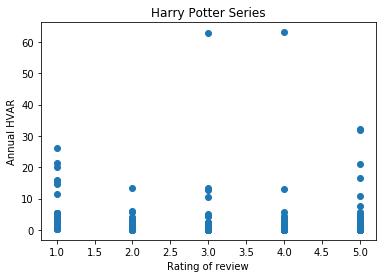

In [26]:
plt.scatter(x=hp.overall,y=hp.HVAR)
plt.ylabel("Annual HVAR")
plt.xlabel("Rating of review")
plt.title("Harry Potter Series")

In [15]:
hqts = pd.DataFrame({'x':np.arange(0,1,.05),\
                   'HP1':hp[hp.asin == "043920352X"].HVAR.quantile(np.arange(0,1,.05)),\
                  'HP2':hp[hp.asin == "0439064864"].HVAR.quantile(np.arange(0,1,.05)),\
                     'HP3':hp[hp.asin =="0439136350"].HVAR.quantile(np.arange(0,1,.05)),\
                   'HP4':hp[hp.asin == "0439139597"].HVAR.quantile(np.arange(0,1,.05)),\
                   'HP5':hp[hp.asin == "043935806X"].HVAR.quantile(np.arange(0,1,.05)),\
                   'HP6':hp[hp.asin == "030728364X"].HVAR.quantile(np.arange(0,1,.05))})

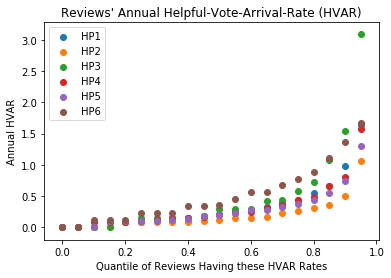

In [18]:
# multiple line plot
plt.scatter( x='x', y='HP1', data=hqts)
plt.scatter( x='x', y='HP2', data=hqts)
plt.scatter( x='x', y='HP3', data=hqts)
plt.scatter( x='x', y='HP4', data=hqts)
plt.scatter( x='x', y='HP5', data=hqts)
plt.scatter( x='x', y='HP6', data=hqts)
plt.legend()
plt.title("Reviews' Annual Helpful-Vote-Arrival-Rate (HVAR)")
plt.ylabel("Annual HVAR")
plt.xlabel("Quantile of Reviews Having these HVAR Rates")
plt.savefig("HP_reviews_annual_HVAR.png")

I think that's still close enough to the elbow that I'll try this with the small training set next. I could see the bend being closer to 80% now. Perhaps I'll try narrowing the dataset to books with 5 or more reviews, and we could try comparing the bottom 20% in terms of annual HVAR vs the top 20%.